In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.neighbors import KernelDensity  # kernel density estimation
from mpmath import jtheta  # jacobi elliptic theta function

Import list of all minor planet discoveries from MPC and list of all NEOs with $17 < H < 25$ from the NASA SBDB, using the same data set as Granvik 2016, 2017, 2018:

In [2]:
# list of minor planet discoveries from the MPC
discovery_data = pd.read_json('numberedmps.json').T
# list of all NEOs with 17 < H < 25 from NASA SBDB:
all_neos = pd.read_csv('all_17_25_neos.csv')

Filtering list of minor planet discoveries to only consider discoveries made by CSS between $2005$ and $2012$:

In [3]:
# Discoverers are 'CSS' or 'Catalina Sky Survey' and discovery date is between January 1, 2005 and December 31, 2012
css_discoveries = discovery_data[((discovery_data.Discoverers == 'CSS') | (discovery_data.Discoverers == 'Catalina Sky Survey')) 
& ('2005-01-01' < discovery_data.Discovery_date) & (discovery_data.Discovery_date < '2012-12-31')]
# reset index since it's actually the minor planet number
css_discoveries['mp_number'] = css_discoveries.index.astype(str)
css_discoveries.reset_index(drop=True, inplace=True)
# convert Name from nan to empty string
css_discoveries = css_discoveries.fillna('')
# make full name column by combining the number, name (if it has one) and principal designation
css_discoveries['full_name'] = css_discoveries.mp_number + css_discoveries.Name + ' (' + css_discoveries.Principal_desig + ')'

/tmp/ipykernel_234387/4109132552.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  css_discoveries['mp_number'] = css_discoveries.index.astype(str)


In [4]:
np.min(css_discoveries.Discovery_date), np.max(css_discoveries.Discovery_date)

('2005-01-06', '2012-12-21')

Now filtering list of NEOs with $17 < H < 25$ to only include the ones discovered by CSS, and getting their $q$ values:

In [5]:
# all NEOs discovered by CSS:
css_neos = all_neos[all_neos.full_name.isin(css_discoveries.full_name)]
# css_neos[css_neos.full_name == '(2006 JY26)']
css_qs = css_neos.q

Importing the Monte Carlo cloned impactors and computing their $q$ (perihelion distance) values from $a$ and $e$:

$q = a\left(1 - e\right)$

In [6]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

# get orbital param variables from the numpy file
a, e, i, peri, node, M = orb_param_array_all_events.T
# compute q from q = a * (1. - e)
impactor_qs = (a * (1. - e)).reshape(-1)

Plotting normalized histograms for the $q$ values of the cloned impactors and the CSS NEOs:

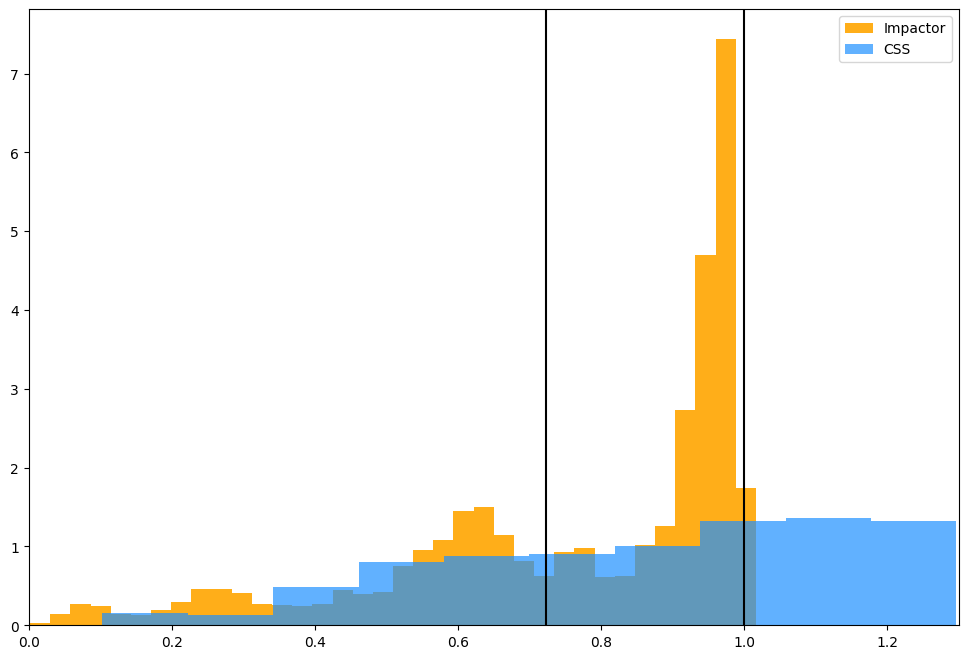

In [7]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs, bins='auto', color = 'orange', label = 'Impactor', density=True, alpha=0.9)
plt.hist(css_qs, bins='auto', color='dodgerblue', label = 'CSS', density=True, alpha=0.7)
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Compare using a K-S test and find the $p$-value:

In [8]:
import scipy.stats
scipy.stats.ks_2samp(impactor_qs, css_qs).pvalue

3.194889573917717e-34

Impactors do not appear to show the same bias as the CSS objects...